This document uses classical ML algorithms to predict NFL player injury (Logistic Regression, Stochastic Gradient Descent, Gradient Boosted trees)

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import f_classif, SelectKBest, VarianceThreshold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    make_scorer,
    precision_recall_curve, 
    roc_auc_score, 
    roc_curve
)
from sklearn.model_selection import learning_curve, train_test_split, StratifiedShuffleSplit, KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample, shuffle
from scipy.stats import ttest_ind
from imblearn.over_sampling import SMOTE
from tabulate import tabulate

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

### Preprocessing 

In [2]:
play2024_df = pd.read_csv("data/play_by_play_2024.csv")
injury2024_df = pd.read_csv("data/injuries_2024.csv")

In [3]:
def first_last_a(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0]}.{parts[1]}"

In [4]:
def first_last_b(name):
    parts = name.split(" ", 1)
    return f"{parts[0][0:2]}.{parts[1]}"

In [5]:
def merge_play_injury_dfs(play_df, injury_df):

    # preprocessing
    injury_df["date"] = pd.to_datetime(injury_df['date_modified'])
    play_df["date"] = pd.to_datetime(play_df['game_date'])
    injury_df['date'] = injury_df['date'].dt.tz_localize(None)
    play_df['date'] = play_df['date'].dt.tz_localize(None)

    # filtering
    plays_with_injuries = play_df[play_df['desc'].str.contains("was injured", na=False)]
    pattern = r'(\w+\.(?:\w|-|\.|\')+(?: \w+)*) was injured'
    # Extract the injured player's name from the desc column
    injured_players = plays_with_injuries.loc[:, "desc"].str.extract(pattern)

    # concatenation
    plays_with_injuries = pd.concat([plays_with_injuries, injured_players], axis=1)
    plays_with_injuries.rename(columns={0: "injured_player"}, inplace=True)
    plays_with_injuries = plays_with_injuries.reset_index(drop=True)
    
    # merging
    injuries = []
    for (week, team), group_injury_df in injury_df.groupby(['week', 'team']):
        group_play_df = plays_with_injuries[(plays_with_injuries['week'] == week) & ((plays_with_injuries['home_team'] == team) | (plays_with_injuries['away_team'] == team))]

        group_injury_df = group_injury_df[group_injury_df.date >= group_play_df.date.max()]

        group_injury_df["first_type"] = group_injury_df['full_name'].apply(first_last_a)
        group_injury_df["second_type"] = group_injury_df['full_name'].apply(first_last_b)

        x = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="first_type", how="inner")
        y = pd.merge(group_play_df, group_injury_df, left_on="injured_player", right_on="second_type", how="inner")

        injuries.append(pd.concat([x, y], axis = 0, ignore_index=True))

    plays_with_injuries_and_injury_record = (pd.concat(injuries, axis=0, ignore_index=True)).drop(columns=["first_type", "second_type"])
    plays_with_injuries_and_injury_record = plays_with_injuries_and_injury_record.sort_values('play_id', ascending=False).drop_duplicates(subset=['week_x', 'full_name', "team"], keep='first')

    return plays_with_injuries, plays_with_injuries_and_injury_record
#returns (plays where injuries occurred, plays were injuries occurred and missed time)

In [6]:
def populate_cols_in_play_df(play_df, plays_with_injuries, plays_with_injuries_and_injury_record):
    columns_to_check = ['play_id', 'game_id']
    play_df["was_injured"] = 0
    play_df["missed_time"] = 0
    play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries[columns_to_check].apply(tuple, 1)), 'was_injured'] = 1
    play_df.loc[play_df[columns_to_check].apply(tuple, 1).isin(plays_with_injuries_and_injury_record[columns_to_check].apply(tuple, 1)), 'missed_time'] = 1

    return play_df

In [7]:
plays_with_injuries_2024, plays_with_injuries_and_injury_record_2024 = merge_play_injury_dfs(play2024_df, injury2024_df)
# Print number of rows for each returned table
print("Rows in plays_with_injuries_2024:", len(plays_with_injuries_2024))
print("Rows in plays_with_injuries_and_injury_record_2024:", len(plays_with_injuries_and_injury_record_2024))

Rows in plays_with_injuries_2024: 457
Rows in plays_with_injuries_and_injury_record_2024: 185


In [8]:
play2024_df = populate_cols_in_play_df(play2024_df, plays_with_injuries_2024, plays_with_injuries_and_injury_record_2024)

In [9]:
# dropping meta data columns
play2024_df = play2024_df.drop(columns=["play_id","game_id","old_game_id"])

#fill NaN values with 0
play2024_df = play2024_df.fillna(0)

In [10]:
#splitting data into training and testing
X = play2024_df.drop(columns=["was_injured", "missed_time"])
y = play2024_df["was_injured"]

In [11]:
print("X shape:", X.shape)

X shape: (26345, 370)


In [12]:
# converts categorical data to numeric values
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
label_encoder = LabelEncoder()

for col in categorical_cols:
    if X[col].dtype == 'object':
        X[col] = label_encoder.fit_transform(X[col].astype(str))

X['date'] = pd.to_datetime(X['date'])

X['game_month'] = X['date'].dt.month
X['game_day'] = X['date'].dt.day

# Drop the original 'game_date' column if not needed
X = X.drop(columns=['date'])

In [13]:
def remove_low_variance_features(X, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X)
    return X.columns[selector.get_support()]

In [14]:
high_variance_features = remove_low_variance_features(X)

# remove low variance features
print("Number of features before removing low variance features:", X.shape[1])
X = X[high_variance_features]
print("Number of features after removing low variance features:", len(X.columns))

Number of features before removing low variance features: 371
Number of features after removing low variance features: 284


In [15]:
fvalue_selector = SelectKBest(f_classif, k=128)
X_kbest = fvalue_selector.fit_transform(X, y)
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_kbest.shape[1])

Original number of features: 284
Reduced number of features: 128


In [16]:
X = pd.DataFrame(X_kbest)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Distribution of classes in y_train:", y_train.value_counts())
print("---------------------")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Distribution of classes in y_test:", y_test.value_counts())

X_train shape: (23710, 128)
y_train shape: (23710,)
Distribution of classes in y_train: was_injured
0    23301
1      409
Name: count, dtype: int64
---------------------
X_test shape: (2635, 128)
y_test shape: (2635,)
Distribution of classes in y_test: was_injured
0    2587
1      48
Name: count, dtype: int64


In [17]:
# conduct synthetic data generation for the minority class (injured players)

smote = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=10)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Distribution of classes in y_train_resampled:", y_train_resampled.value_counts())

Distribution of classes in y_train_resampled: was_injured
0    23301
1    23301
Name: count, dtype: int64


In [18]:
#normalize all columns in the dataframe
scaler = StandardScaler()

# get just numeric columns
num_cols = X.select_dtypes(include=[np.number]).columns

In [19]:
X_train_resampled[num_cols] = scaler.fit_transform(X_train_resampled[num_cols])
X_train_resampled = pd.DataFrame(X_train_resampled)
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("Number of injury cases:", len(y_train_resampled[y_train_resampled == 1]))
print("Number of non-injury cases:", len(y_train_resampled[y_train_resampled == 0]))

Number of injury cases: 23301
Number of non-injury cases: 23301


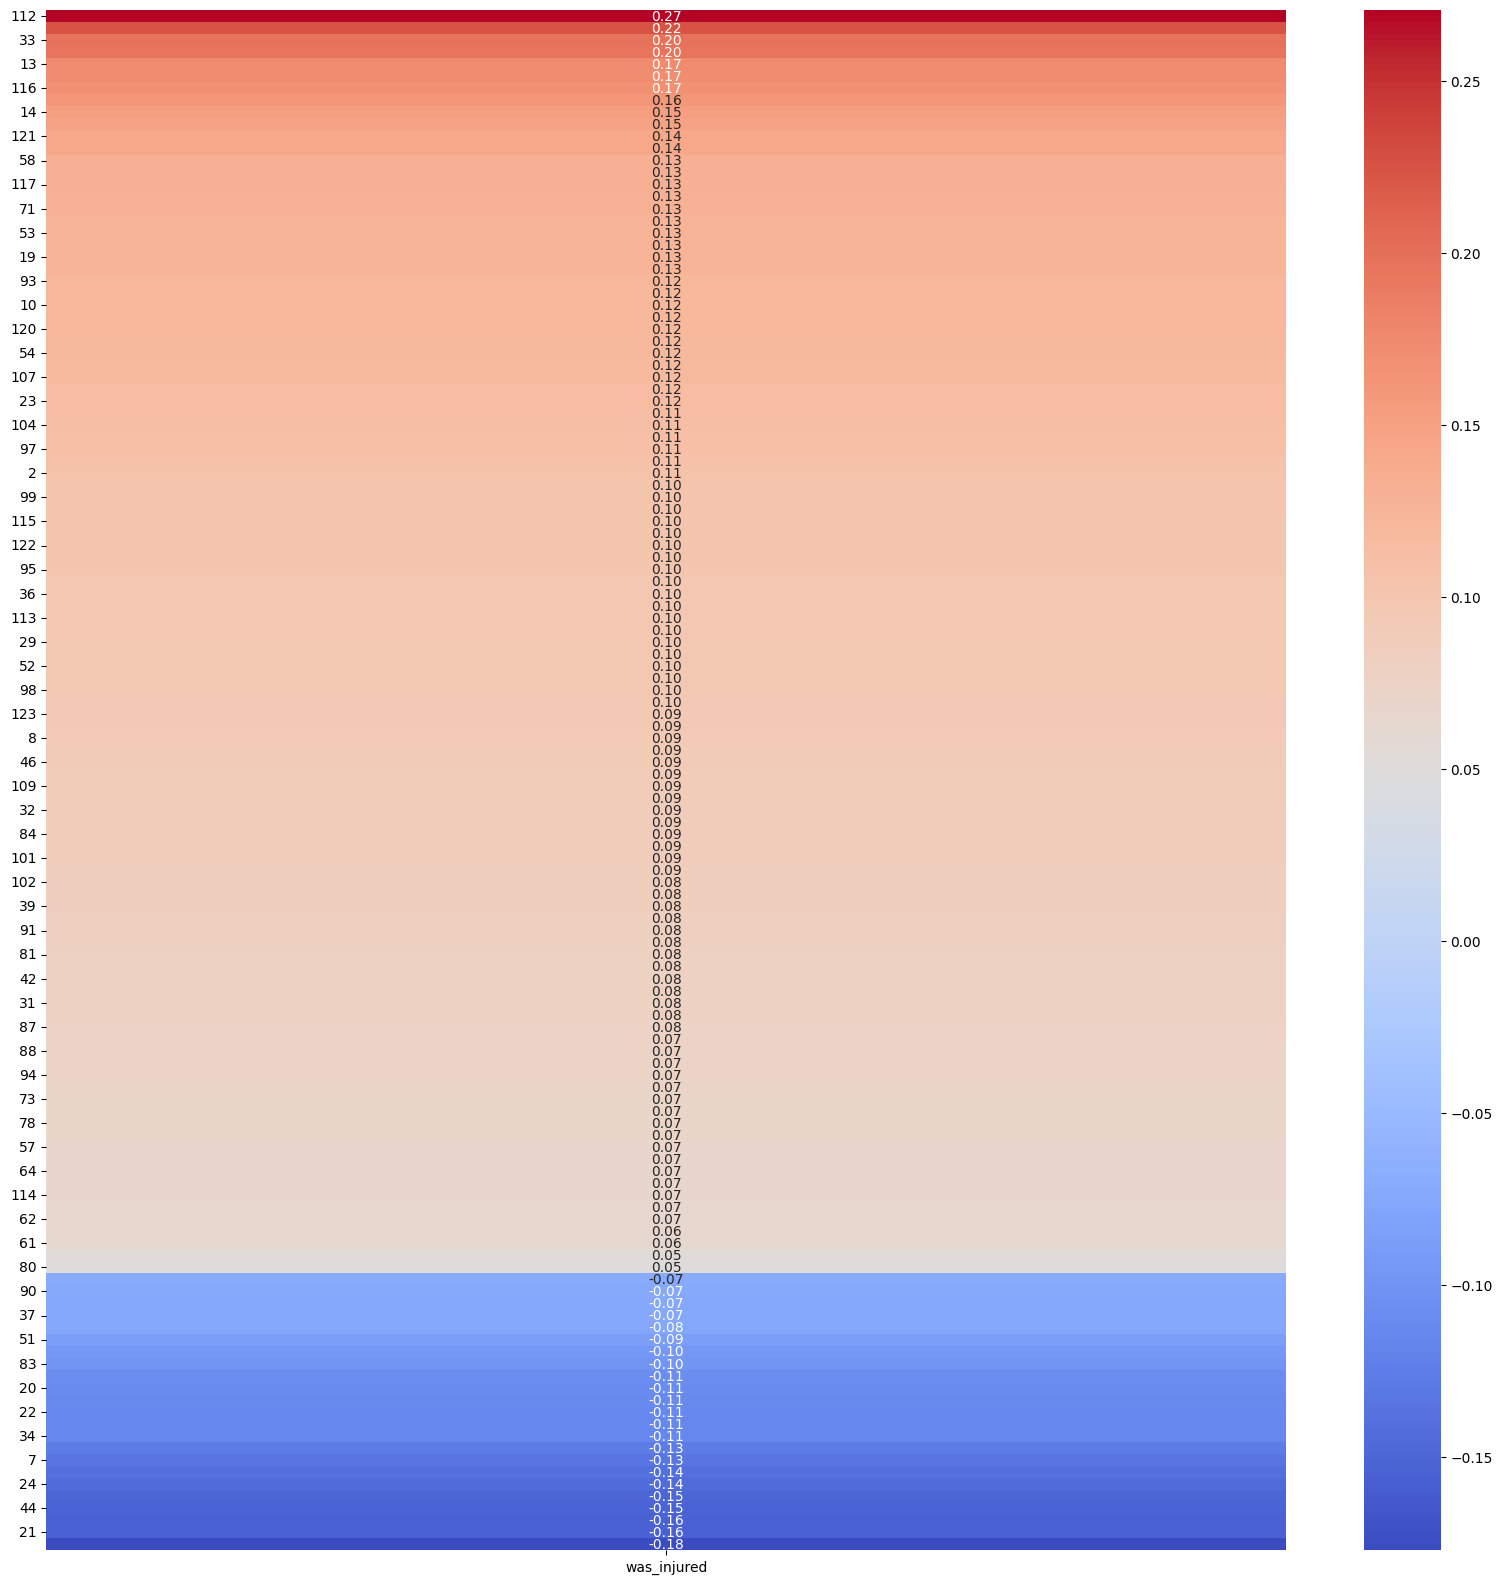

<Figure size 640x480 with 0 Axes>

In [20]:
#display correlation matrix
new_df = pd.concat([X_train_resampled, y_train_resampled], axis=1)
corr = new_df.corr()[["was_injured"]].sort_values(by="was_injured", ascending=False)
corr = corr.drop("was_injured")
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()
plt.savefig("correlation_matrix.png")

In [21]:
X_train_injury = X_train[y_train == 1]
X_train_no_injury = X_train[y_train == 0]

print("X_train_injury shape:", X_train_injury.shape)
print("X_train_no_injury shape:", X_train_no_injury.shape)

X_train_no_injury_downsampled = resample(X_train_no_injury, replace=False, n_samples=len(X_train_injury), random_state=42)

X_train_downsampled = pd.concat([X_train_no_injury_downsampled, X_train_injury])
y_train_downsampled = pd.Series([0] * len(X_train_no_injury_downsampled) + [1] * len(X_train_injury))

#shuffle the data
X_train_downsampled, y_train_downsampled = shuffle(X_train_downsampled, y_train_downsampled, random_state=42)

print("X_train_downsampled shape:", X_train_downsampled.shape)

X_train_injury shape: (409, 128)
X_train_no_injury shape: (23301, 128)
X_train_downsampled shape: (818, 128)


### Modeling

In [22]:
classifiers = {"Logistic Regression": LogisticRegression(), "SGD Classifier": SGDClassifier(), "Gradient Boosting Tree": GradientBoostingClassifier()}

Classifier: LogisticRegression
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.68      0.80      2587
           1       0.03      0.58      0.06        48

    accuracy                           0.68      2635
   macro avg       0.51      0.63      0.43      2635
weighted avg       0.97      0.68      0.79      2635



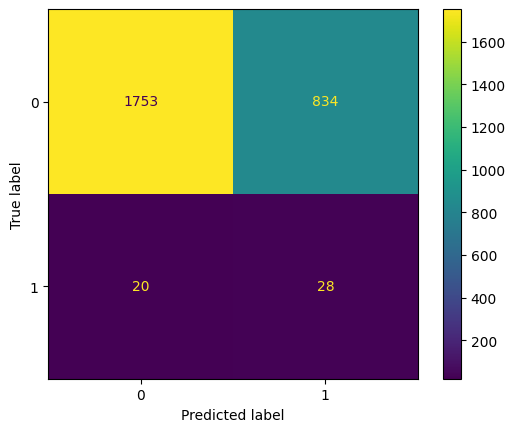

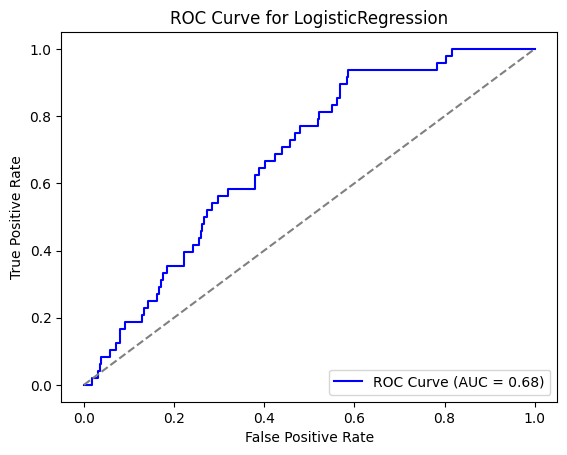

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

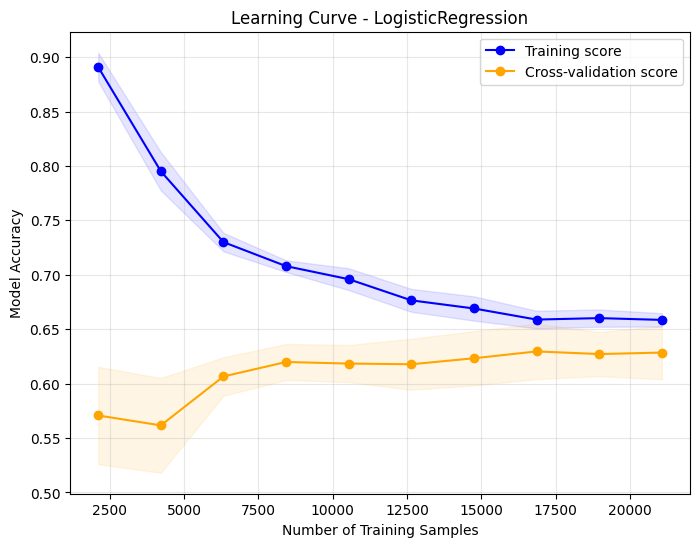

Classifier: SGDClassifier
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.67      0.80      2587
           1       0.03      0.60      0.06        48

    accuracy                           0.67      2635
   macro avg       0.51      0.64      0.43      2635
weighted avg       0.97      0.67      0.78      2635



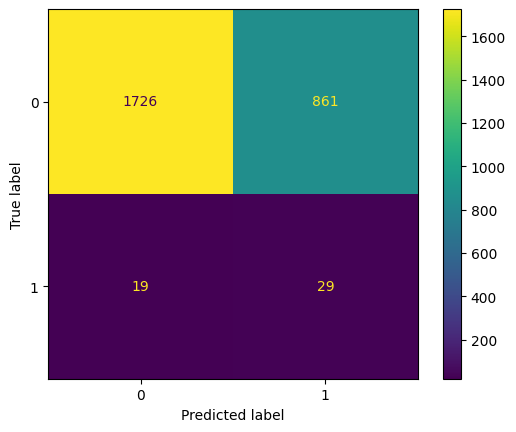

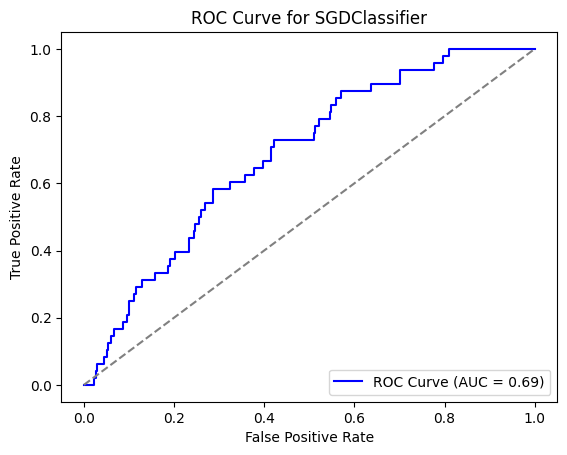

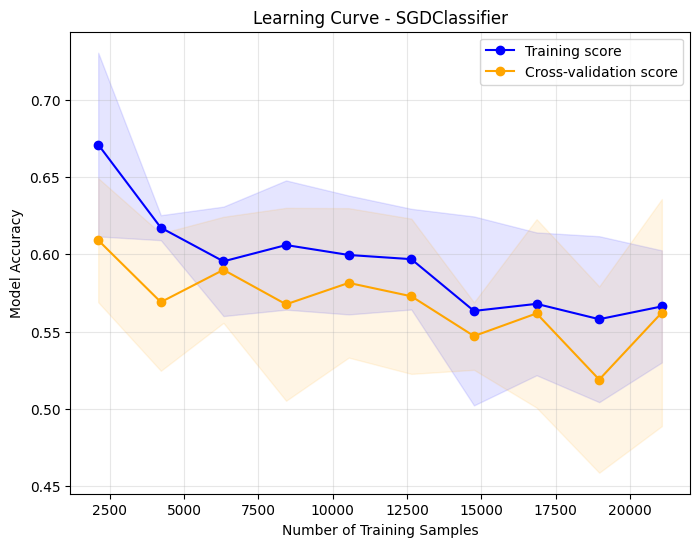

Classifier: GradientBoostingClassifier
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2587
           1       0.00      0.00      0.00        48

    accuracy                           0.98      2635
   macro avg       0.49      0.50      0.50      2635
weighted avg       0.96      0.98      0.97      2635



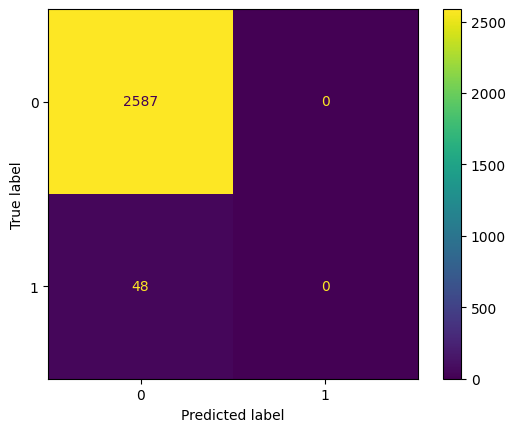

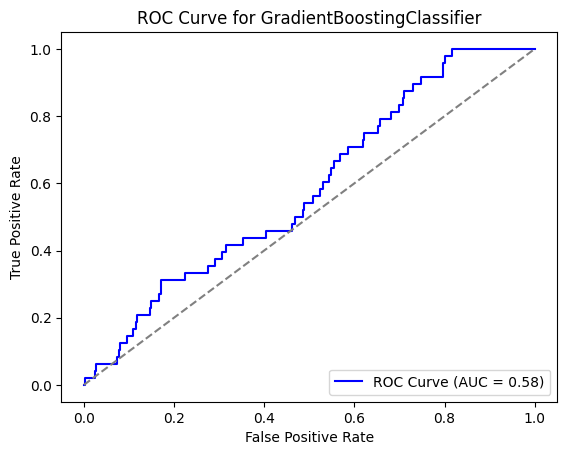

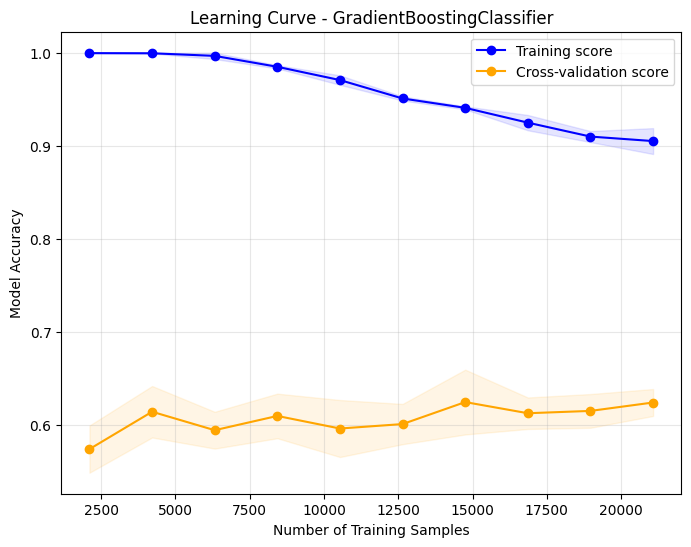

In [23]:
for key, classifier in classifiers.items():
    classifier.fit(X_train_resampled, y_train_resampled)
    print(f"\033[1;36m{'Classifier: '}{classifier.__class__.__name__}\033[0m")
    print("Classification Report: ")
    print(classification_report(y_test, classifier.predict(X_test)))

    cm = confusion_matrix(y_test, classifier.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    if hasattr(classifier, "predict_proba"):  # For models that support probability prediction
        y_prob = classifier.predict_proba(X_test)[:, 1]
    elif hasattr(classifier, "decision_function"):  # For models like SVM that use decision_function
        y_prob = classifier.decision_function(X_test)
    else:
        print(f"Skipping ROC for {classifier.__class__.__name__}, no probability output available.")
        continue
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {classifier.__class__.__name__}")
    plt.legend(loc="lower right")
    plt.show()

    if hasattr(classifier, "predict_proba"):  # For models that support probability prediction
        scorer = make_scorer(roc_auc_score, needs_proba=True)

        # Generate the learning curve
        train_sizes, train_scores, test_scores = learning_curve(
            estimator=classifier,
            X=X,  # Entire dataset (X)
            y=y,  # Entire target labels (y)
            cv=5,  # 5-fold cross-validation
            scoring=scorer,
            train_sizes=np.linspace(0.1, 1.0, 10),  # Vary training set size from 10% to 100%
            n_jobs=-1  # Use all available CPU cores
        )

        # Calculate mean and standard deviation for training and test scores
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot the learning curve
        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
        plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Cross-validation score')
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='orange')
        plt.title(f'Learning Curve - {classifier.__class__.__name__}')
        plt.xlabel('Number of Training Samples')
        plt.ylabel('Model Accuracy')
        plt.legend(loc='best')
        plt.grid(alpha=0.3)
        plt.show()
    elif hasattr(classifier, "decision_function"):  # For models like SVM that use decision_function
        def custom_auc_scorer(estimator, X, y):
            decision_scores = estimator.decision_function(X)  # Get decision function scores
            return roc_auc_score(y, decision_scores)

        # Wrap the scorer
        scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=False, needs_threshold=True)
        
        # Generate the learning curve using cross validation
        train_sizes, train_scores, test_scores = learning_curve(
            estimator=classifier,
            X=X,  # Entire feature set
            y=y,  # Target labels
            cv=5,  # 5-fold cross-validation
            scoring=scorer,  # Pass custom scorer directly
            train_sizes=np.linspace(0.1, 1.0, 10),  # Training sizes from 10% to 100%
            n_jobs=-1  # Use all available cores
        )

        # Calculate mean and standard deviation for training and test scores
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot the learning curve
        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
        plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Cross-validation score')
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='orange')
        plt.title('Learning Curve - SGDClassifier')
        plt.xlabel('Number of Training Samples')
        plt.ylabel('Model Accuracy')
        plt.legend(loc='best')
        plt.grid(alpha=0.3)
        plt.show()